# ACER CORE map playground

In [ ]:
!pip install cartopy
!pip install shapely
!pip install matplotlib






## CORE Region map
Fixed Crimea

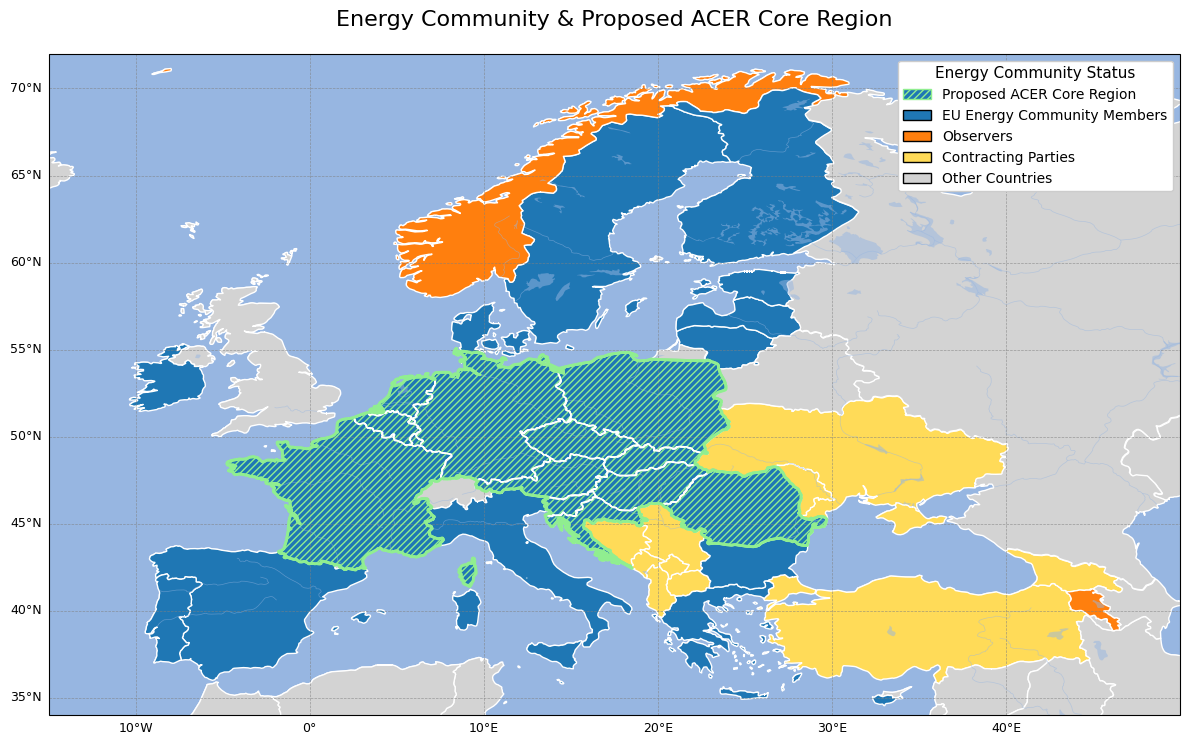

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from matplotlib.patches import Patch

# --- 1. Membership sets ---
EU_MEMBERS = {
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czech Republic',
    'Denmark','Estonia','Finland','France','Germany','Greece','Hungary',
    'Ireland','Italy','Latvia','Lithuania','Luxembourg','Malta',
    'Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain','Sweden'
}
OBSERVERS = {'Armenia','Norway','Türkiye'}
CONTRACTING_PARTIES = {
    'Albania','Bosnia and Herzegovina','Kosovo','North Macedonia',
    'Georgia','Republic of Moldova','Montenegro','Serbia','Ukraine','Moldova','Turkey'
}

# --- 2. Core region ---
CORE_REGION = {
    'Austria','Belgium','Croatia','Czech Republic','France','Germany',
    'Hungary','Luxembourg','Netherlands','Poland','Romania','Slovakia','Slovenia'
}

# --- 3. Figure & extent ---
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-15,50,34,72], crs=ccrs.PlateCarree())

# --- 4. Load country shapes ---
shp_path = shpreader.natural_earth('50m', 'cultural', 'admin_0_countries')
reader  = shpreader.Reader(shp_path)
records = list(reader.records())

# --- 4b. Extract & split Russia’s geometry into “main” vs. “Crimea” ---
# pull out the Russia record
rus_rec = next(r for r in records if r.attributes['ADM0_A3']=='RUS')
# remove it from the main records list
records = [r for r in records if r is not rus_rec]

# split its MultiPolygon
parts        = list(rus_rec.geometry.geoms) \
                   if hasattr(rus_rec.geometry, 'geoms') \
                   else [rus_rec.geometry]
rus_main, crimea_geom = [], None

for poly in parts:
    lon, lat = poly.centroid.x, poly.centroid.y
    # approximate lat/lon box for Crimea
    if 32 < lon < 37 and 43 < lat < 47:
        crimea_geom = poly
    else:
        rus_main.append(poly)

rus_main_geom = unary_union(rus_main)


# --- 5. Draw every country except Russia ---
for rec in records:
    name = rec.attributes['NAME_LONG']
    geom = rec.geometry

    if   name in EU_MEMBERS:
        fc = '#1f77b4'    # blue
    elif name in OBSERVERS:
        fc = '#ff7f0e'    # orange
    elif name in CONTRACTING_PARTIES:
        fc = '#ffdb58'    # gold
    else:
        fc = 'lightgray'  # other

    ax.add_geometries([geom],
                      crs=ccrs.PlateCarree(),
                      facecolor=fc,
                      edgecolor='white',
                      linewidth=1)

# --- 5b. Draw main-Russia (minus Crimea) in grey ---
ax.add_geometries([rus_main_geom],
                  crs=ccrs.PlateCarree(),
                  facecolor='lightgray',
                  edgecolor='white',
                  linewidth=1)

# --- 5c. Draw Crimea as part of Ukraine (gold), on top ---
if crimea_geom is not None:
    ax.add_geometries([crimea_geom],
                      crs=ccrs.PlateCarree(),
                      facecolor='#ffdb58',
                      edgecolor='white',
                      linewidth=1,
                      zorder=4)


# --- 6. Core-Region hatch overlay ---
from shapely.ops import unary_union
core_geoms = [
    rec.geometry for rec in records
    if rec.attributes['NAME_LONG'] in CORE_REGION
]
core_union = unary_union(core_geoms)

ax.add_geometries([core_union],
                  crs=ccrs.PlateCarree(),
                  facecolor='none',
                  edgecolor='lightgreen',
                  hatch='/////',
                  linewidth=2,
                  zorder=5)
# white inner borders for Core members
for rec in records:
    if rec.attributes['NAME_LONG'] in CORE_REGION:
        ax.add_geometries([rec.geometry],
                          crs=ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor='white',
                          linewidth=1,
                          zorder=6)
        
# Core member area big outline
ax.add_geometries([core_union],
                  crs=ccrs.PlateCarree(),
                  facecolor='none',
                  edgecolor='lightgreen',
                  linewidth=2,
                  zorder=7)

# --- 7. Contextual features & grid ---
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.5)
ax.add_feature(cfeature.RIVERS.with_scale('50m'), alpha=0.5, linewidth=0.5)

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
                  color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size':9}
gl.ylabel_style = {'size':9}


# --- 8. Legend ---
legend_elems = [
    Patch(facecolor='#1f77b4', edgecolor='lightgreen', hatch='/////',
          label='Proposed ACER Core Region'),
    Patch(facecolor='#1f77b4', edgecolor='black',
          label='EU Energy Community Members'),
    Patch(facecolor='#ff7f0e', edgecolor='black',
          label='Observers'),
    Patch(facecolor='#ffdb58', edgecolor='black',
          label='Contracting Parties'),
    Patch(facecolor='lightgray', edgecolor='black',
          label='Other Countries'),
]
ax.legend(handles=legend_elems,
          loc='upper right',
          title='Energy Community Status',
          framealpha=1,
          fontsize=10,
          title_fontsize=11)

# --- 9. Title & show/save ---
plt.title('Energy Community & Proposed ACER Core Region',
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()
# plt.savefig('energy_community_core_region.png', dpi=300)
